## MNIST

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/numbers/"
sz=299
arch=resnext50
bs=28

Got to load architecture with precompute == True, to setup layers. Also has to create model for first time. Can take time to even get to the pretraining of the model. Also, no augmenting of transforms because reversal or upside could mean something else (i.e. 5 upside down could be a 2???)

In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=None, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4,  val_name='valid', test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

Find the appropriate learning rate.

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|███████   | 1029/1461 [00:05<00:02, 173.26it/s, loss=1.5]  


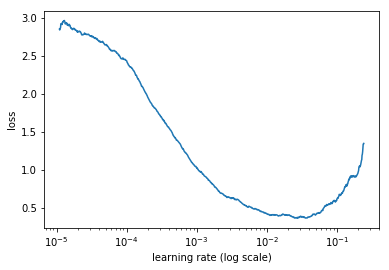

In [8]:
lrf=learn.lr_find()
learn.sched.plot()

Got to remove the precompute because only allows use of current activations. Does not allow augmentation of new data. False changes that, now we can use augmentation to get more up to date augmentations (input dependent)

In [9]:
learn.fit(1e-2, 1)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      0.248824   0.09907    0.966541  



I think the difference in validation and training is that we are still using the bottom layers in default setup. Those activations dont change unless layers are unfrozen.

In [10]:
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.180095   0.078866   0.978571  
    1      0.155978   0.076924   0.975893                      



[0.076923504, 0.9758928567171097]

In [11]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [12]:
learn.fit(lr, 3, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      0.044461   0.0103     0.997321  
    1      0.019007   0.006545   0.997321                       
    2      0.032547   0.008927   0.996429                       
    3      0.012147   0.007933   0.997321                        
    4      0.01962    0.005145   0.997321                       
    5      0.005042   0.003529   0.998214                        



[0.0035294227, 0.9982142865657806]

In [13]:
learn.save('num_all_50')

In [14]:
learn.load('num_all_50')

Test Time Augmentation is awesome. accuracy just jumped to a third 9!!!!

In [15]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.9990999099909991

## Analyzing results

In [16]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[102   0   0   0   0   0   0   0   0   0]
 [  0 108   0   0   0   0   0   0   0   0]
 [  0   0 127   0   0   0   0   0   0   0]
 [  0   0   0 118   0   0   0   0   0   0]
 [  0   0   0   0  98   0   0   0   0   0]
 [  0   0   0   0   0 100   0   0   0   0]
 [  0   0   0   0   0   0 124   0   0   0]
 [  0   1   0   0   0   0   0 117   0   0]
 [  0   0   0   0   0   0   0   0 111   0]
 [  0   0   0   0   0   0   0   0   0 105]]


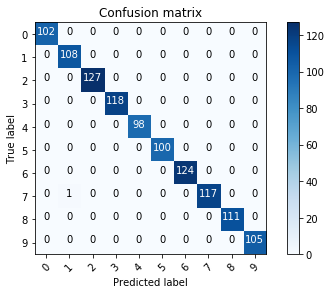

In [17]:
plot_confusion_matrix(cm, data.classes)

In [18]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Incorrect Value


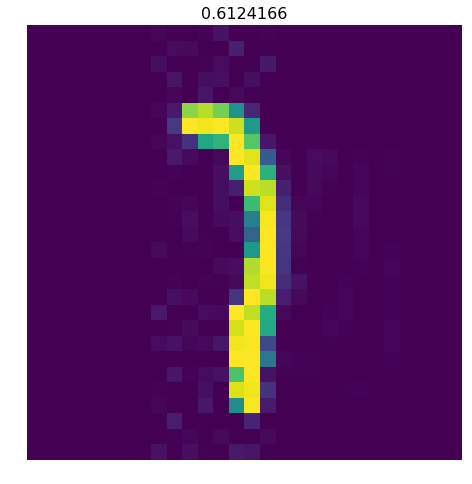

In [22]:
plot_val_with_title(most_by_correct(0, False), "Incorrect Value")

## END